**SMLT ITMO 2021**

Task #3

1. Select one of the datasets with low-resolution images (for example, you can use tf.keras.datasets API (or tf.examples.tutorials for TF 1.X) for loading fashion_mnist, cifar10 or cifar100 datasets);

2. Train conditional variational autoencoder to generate new images of the classes presented in your labeled data. You should update all the necessary hyperparameters in “Conditional VAE MNIST” example in order to fit the characteristics of your dataset (image dimensions, number of images, batch size etc.);**to generate more realistic images you can change the number of layers or even use convolutional type of encoder and decoder.**

3. Plot the learning curves to ensure that the algorithm has been converged and there is no overfitting;

4. Select and plot separately N images for every class in your data which, according to your visual perception, have the best quality (N = Nclasses);

5. Complete a task in a single Jupyter Notebook.



### Corrections:
1. updated generated samples array
2. Plotted intermediate training results

In [ ]:
!pip install tensorflow==2.3.0
!pip install keras==2.4.3

     |████████████████████████████████| 320.4 MB 41 kB/s 
     |████████████████████████████████| 459 kB 37.9 MB/s 
     |████████████████████████████████| 20.1 MB 8.7 MB/s 
     |████████████████████████████████| 2.9 MB 32.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
 

  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [ ]:
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# import cPickle
import tensorflow as tf
# %tensorflow_version 1.x
# from tensorflow.python.keras import layers, models
# from tensorflow.python.keras.layers import *

# from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
# from keras.layers import Conv2D, Conv2DTranspose
# from keras.models import Model
# from keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

# CIFAR10

Here I'm using CIFAR10 dataset for training and testing CVAE

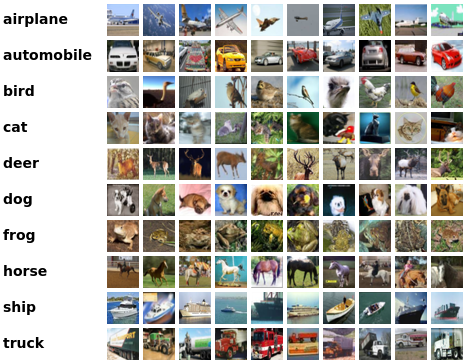

In [ ]:
from IPython.display import display, Image
display(Image("cifar10.png"))

#### Parameters

In [ ]:
img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 15
filters = 32
num_conv = 3
batch_size = 256
samples = []

### Custom call back to save results for each epoch

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model
        self.x_test = x_test
        # self.y_test = y_test

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x_test)
        # print('y predicted: ', y_pred.shape)
        samples.append(y_pred)

## Conditional VAE (Architecture + training)

In [ ]:

# tensorflow uses channels_last
# theano uses channels_first
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)


# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * img_rows / 2 * img_cols / 2, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, img_rows / 2, img_cols / 2)
else:
    output_shape = (batch_size, img_rows / 2, img_cols / 2, filters)


m, n, p = output_shape[1:]
# reshape_decoded = tf.reshape(up_decoded, (int(m), int(n), int(p)))
decoder_reshape = Reshape((int(m), int(n), int(p)))
# decoder_reshape = tf.reshape(output_shape[1:])

decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
print(up_decoded.shape, type(up_decoded), output_shape[1:])

# up_decoded = tf.cast(up_decoded, tf.int32)
# print(up_decoded.shape, type(up_decoded))
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])

# entire model
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


# load dataset
(x_train, _), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)


# training
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None),
        callbacks=[CustomCallback(vae, x_test)])
        # callbacks=[PredictionCallback()])

(None, 8192) <class 'tensorflow.python.framework.ops.Tensor'> (16.0, 16.0, 32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 3)    39          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   416         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_1[0][0]                   
________

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

### Plot the history to see if model converges

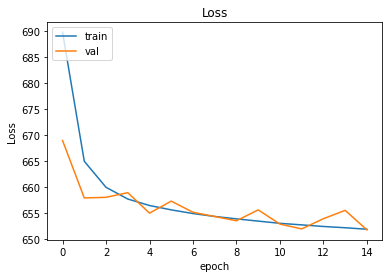

In [ ]:
# import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
indices = []
out_images = []

In [10]:
# get labels
class_images = {}

In [11]:
for i in range(10):
  class_images[i] = []
class_images

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

### Choose N images from each class to display

In [12]:
%%time
done = 0
while done < 10:
  index = np.random.randint(0, 10000, 1)[0]
  label = y_test[index]   # true label
  if len(class_images[label[0]]) == 10:
    # already completed.
    continue
  # image = samples[index]  # generated image
  if index in class_images[label[0]]:
    # already counted
    # do it again
    continue
  else:
    class_images[label[0]].append(index)
  
  if len(class_images[label[0]]) == 10:  #total images required for this class
    done += 1

CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 3.71 ms


In [13]:
class_images

{0: [1712, 5626, 5327, 6729, 6717, 9590, 7356, 489, 9772, 9170],
 1: [7570, 122, 5472, 2042, 796, 5449, 7894, 9339, 2634, 5051],
 2: [4730, 9424, 1995, 2082, 3758, 2912, 138, 4369, 9688, 740],
 3: [4404, 8112, 5822, 8557, 5281, 1208, 3977, 7202, 1883, 77],
 4: [1526, 3545, 1267, 2664, 9205, 2982, 7245, 5252, 1441, 2500],
 5: [5482, 9853, 3323, 8904, 1738, 2650, 4052, 1025, 1812, 4172],
 6: [747, 1140, 1992, 1982, 4702, 4648, 8748, 5423, 512, 3160],
 7: [4803, 220, 2340, 6384, 194, 5273, 1149, 9020, 1566, 571],
 8: [2921, 1223, 4223, 3037, 4865, 8329, 6839, 8460, 2591, 8690],
 9: [8450, 951, 4874, 3504, 9516, 3339, 7067, 4098, 8465, 780]}

In [17]:
X_test.shape

(10000, 32, 32, 3)

In [16]:
l = []
for k in class_images.keys():
  l.append(X_test[class_images[k]])
np.array(l).shape

(10, 10, 32, 32, 3)

In [18]:
# Make one list
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list
l2 = flatten(l)
len(l2)

100

In [1]:
import os
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from tqdm import tqdm

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
!pip install tensorflow==2.4

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 2.9 MB 34.3 MB/s 
     |████████████████████████████████| 462 kB 48.9 MB/s 
     |████████████████████████████████| 3.8 MB 34.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.2
    Uninstalling tensorflow-2.6.

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [24]:
!pip install tensorflow==1.14

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
input_size = 32 * 32 * 3
num_digits = 10

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data
(X_train, y_train), (X_test, y_test) = load_data()

In [ ]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(x, params['z_dim'])
    var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var

def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z,
                            layer,
                            activation=params['activation'])
    mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)


def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x,
                            layer,
                            activation=params['activation'])
    logits = tf.layers.dense(x, num_digits)
    return logits


params = {
    'encoder_layers': [128],                
    'decoder_layers': [128],                
    'digit_classification_layers': [128],   # for conditions
    'activation': tf.nn.sigmoid,            
    'decoder_std': 0.5,                     # std for P(x|z) 
    'z_dim': 10,                            # latent space dimension
    'digit_classification_weight': 10.0,    # for conditions
    'epochs': 100,
    'batch_size': 100,
    'learning_rate': 0.001
}
# sample the vector from latent space, using
# reparametrization
input_size = 32 * 32 * 3
num_digits = 10
images = tf.placeholder(tf.float32, [None, input_size])
# images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])
# encode the image into latent space
encoder_mu, encoder_var = encoder(images,
                                  params['encoder_layers'])
eps = tf.random_normal(shape=[tf.shape(images)[0],
                              params['z_dim']],
                       mean=0.0,
                       stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# classify the digit
digit_logits = digit_classifier(images,
                                params['digit_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# decode latent vector using digit classification condition into the image
decoded_images = decoder(tf.concat([z, digit_prob], axis=1),
                         params['decoder_layers'])

In [ ]:
# loss for reconstructed image
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(
        decoded_images,
        params['decoder_std']
    ).log_prob(images),
    axis=1
)

# loss for the current hidden space distribution parameters
loss_prior = -0.5 * tf.reduce_sum(
    1 + tf.log(encoder_var) - encoder_mu ** 2 - encoder_var,
    axis=1
)

# autoencoder loss
loss_auto_encode = tf.reduce_mean(
    loss_reconstruction + loss_prior,
    axis=0
)

# loss for digit_classification
loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits,
                                                   logits=digit_logits),
    axis=0
)

# final loss
loss = loss_auto_encode + loss_digit_classifier

train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

In [ ]:
# Training
batch_size = 256
samples = []
losses_auto_encode = []
losses_digit_classifier = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(params['epochs']):
        print("Epoch # - ",epoch)
        n_minibatches = int(X_train.shape[0] / batch_size)
        print("Number of minibatches: ", n_minibatches)
        for i in range(n_minibatches):
            # batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
            batch_images = X_train[i*batch_size:(i+1)*batch_size]/255.
            batch_digits = y_train[i*batch_size:(i+1)*batch_size]
            batch_images = np.reshape(batch_images, (batch_size, 32*32*3))
            batch_digits = np.reshape(batch_digits, (batch_size,))
            sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
        
        
        train_loss_auto_encode, train_loss_digit_classifier = sess.run(
            [loss_auto_encode, loss_digit_classifier],
            {images: np.reshape(X_train, (X_train.shape[0], 32*32*3)), 
             digits: np.reshape(y_train, (y_train.shape[0], )) })
        
        losses_auto_encode.append(train_loss_auto_encode)
        losses_digit_classifier.append(train_loss_digit_classifier)
        
        sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
        gen_samples = sess.run(decoded_images,
                               feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
        samples.append(gen_samples)

print("\nTraining completed!")


Epoch # -  0
Number of minibatches:  195
Epoch # -  1
Number of minibatches:  195
Epoch # -  2
Number of minibatches:  195
Epoch # -  3
Number of minibatches:  195
Epoch # -  4
Number of minibatches:  195
Epoch # -  5
Number of minibatches:  195
Epoch # -  6
Number of minibatches:  195
Epoch # -  7
Number of minibatches:  195
Epoch # -  8
Number of minibatches:  195
Epoch # -  9
Number of minibatches:  195
Epoch # -  10
Number of minibatches:  195
Epoch # -  11
Number of minibatches:  195
Epoch # -  12
Number of minibatches:  195
Epoch # -  13
Number of minibatches:  195
Epoch # -  14
Number of minibatches:  195
Epoch # -  15
Number of minibatches:  195
Epoch # -  16
Number of minibatches:  195
Epoch # -  17
Number of minibatches:  195
Epoch # -  18
Number of minibatches:  195
Epoch # -  19
Number of minibatches:  195
Epoch # -  20
Number of minibatches:  195
Epoch # -  21
Number of minibatches:  195
Epoch # -  22
Number of minibatches:  195
Epoch # -  23
Number of minibatches:  195
Ep

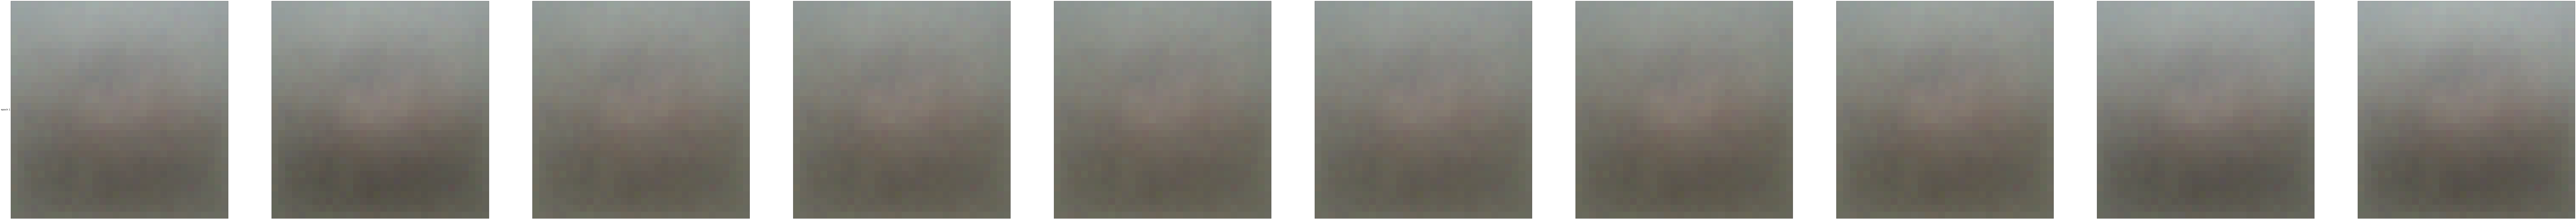

In [ ]:
plot_samples([samples[0]])

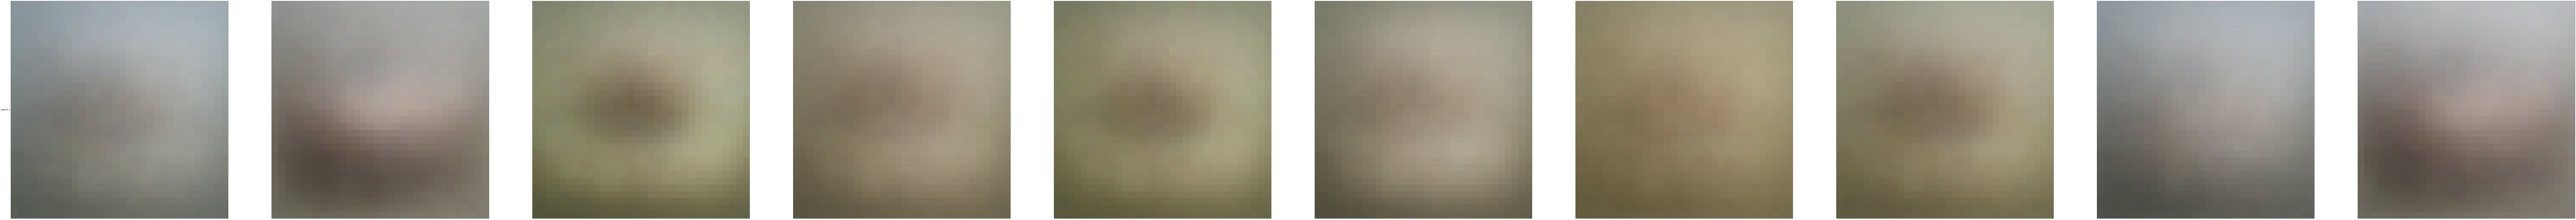

In [ ]:
plot_samples([samples[4]])

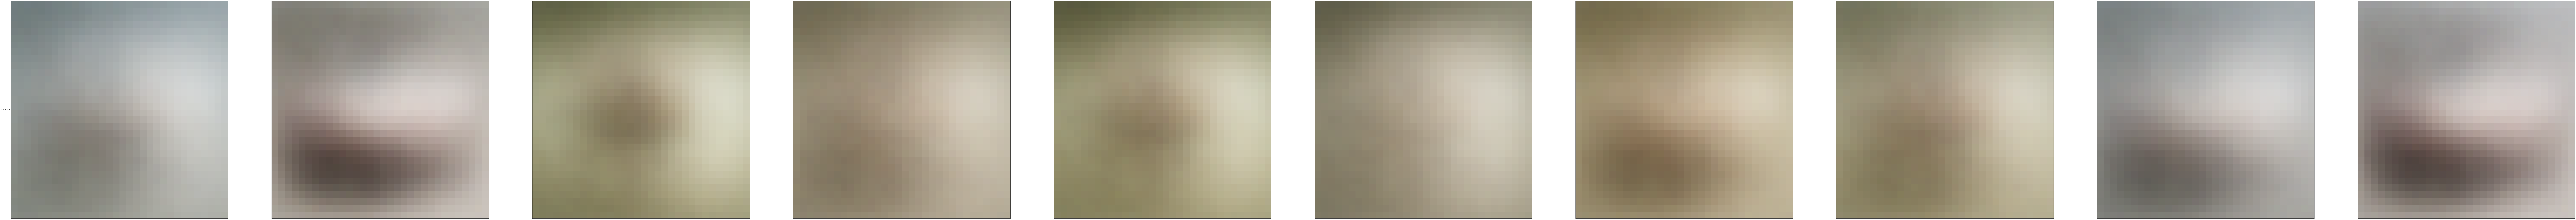

In [ ]:
plot_samples([samples[6]])

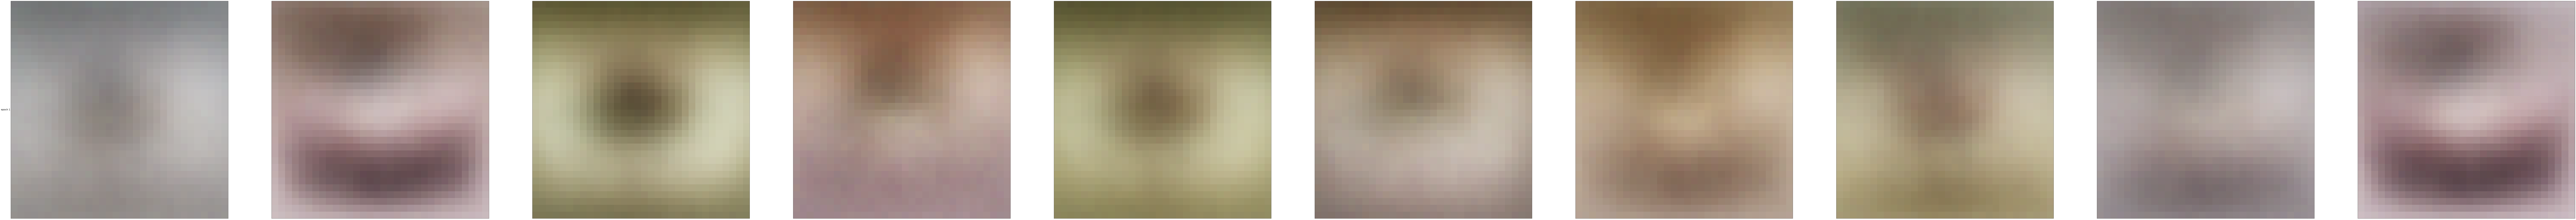

In [ ]:
plot_samples([samples[10]])

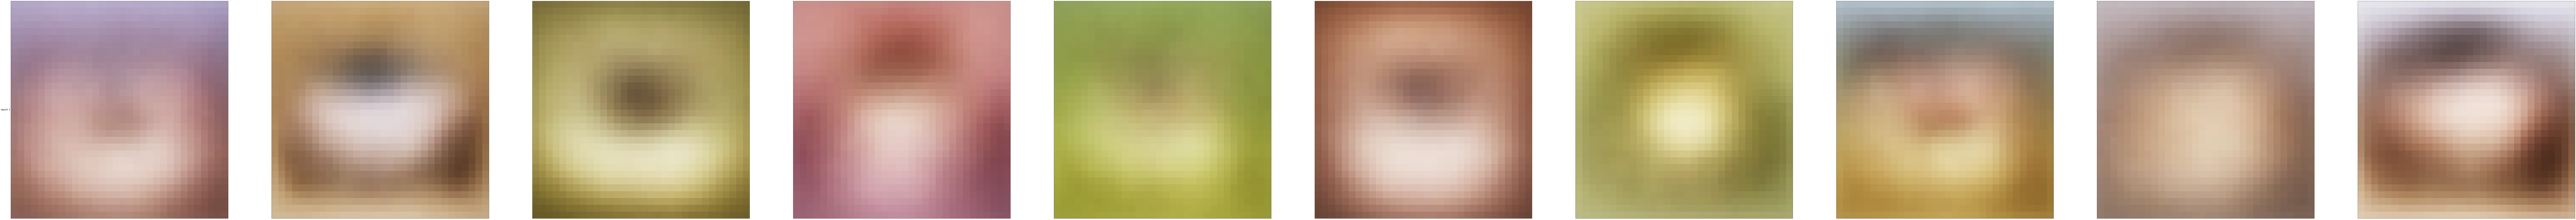

In [ ]:
plot_samples([samples[20]])

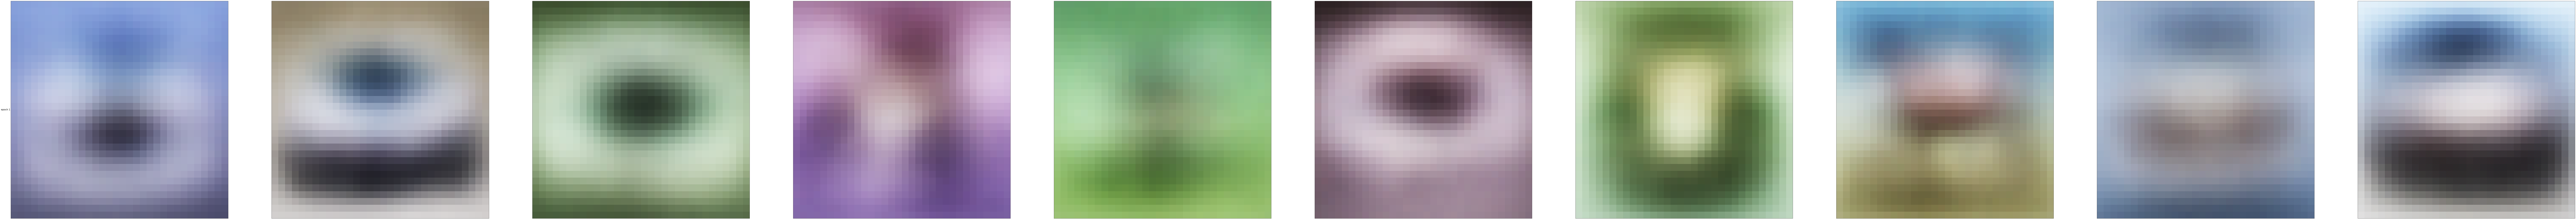

In [ ]:
plot_samples([samples[30]])

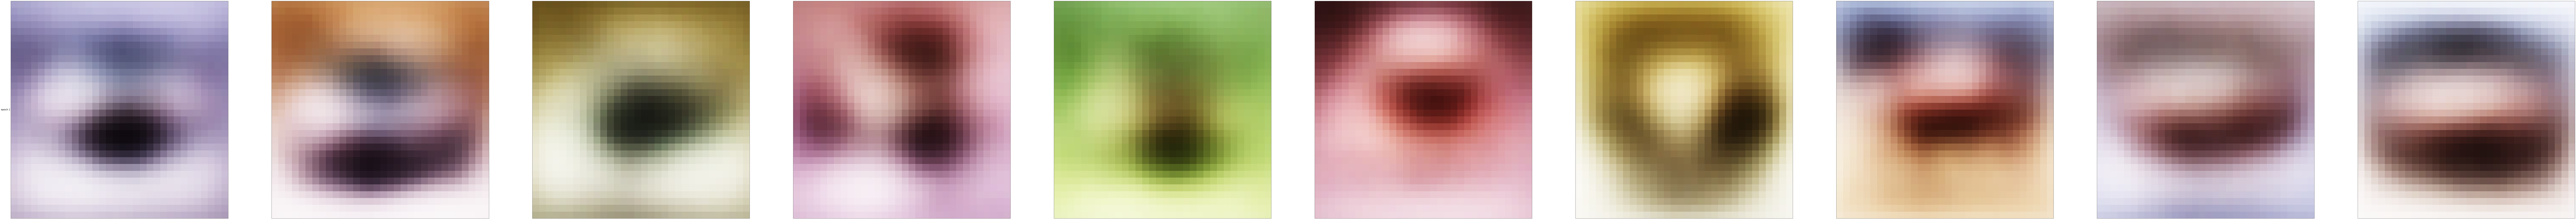

In [ ]:
plot_samples([samples[40]])

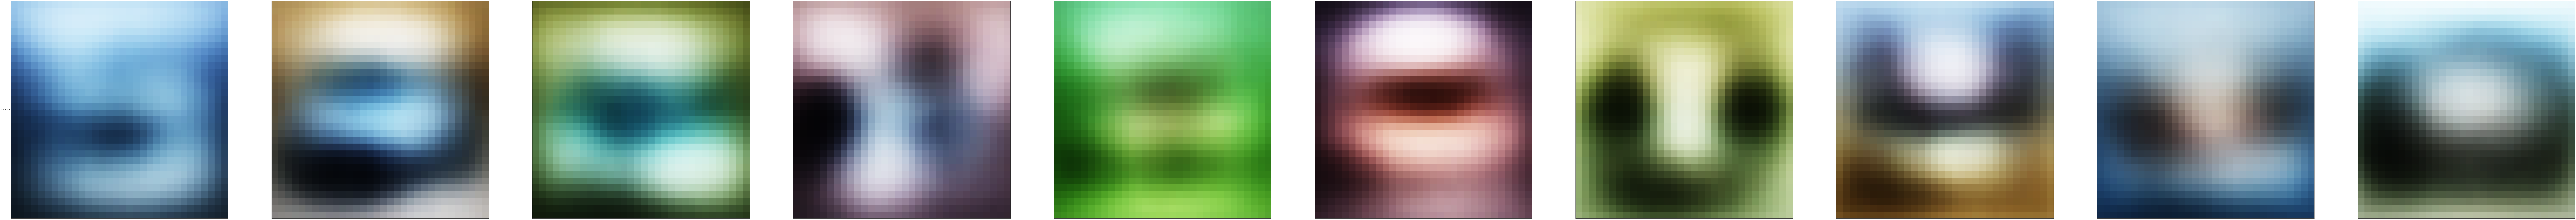

In [ ]:
plot_samples([samples[50]])

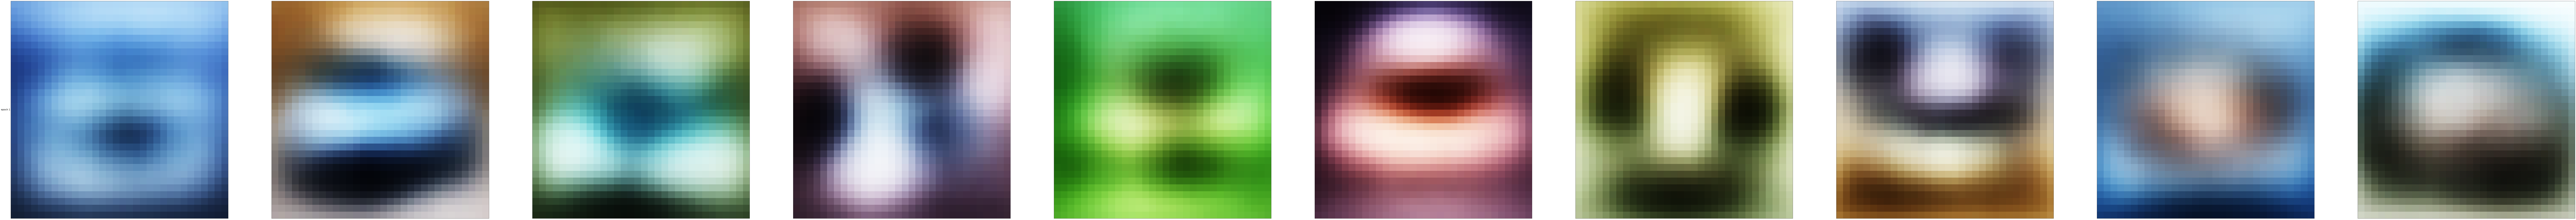

In [ ]:
plot_samples([samples[60]])

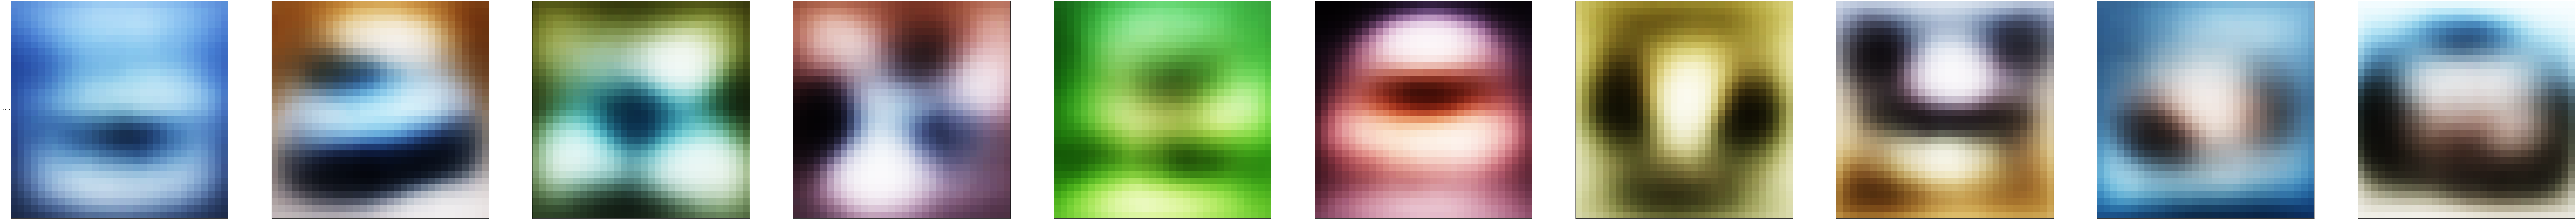

In [ ]:
plot_samples([samples[70]])

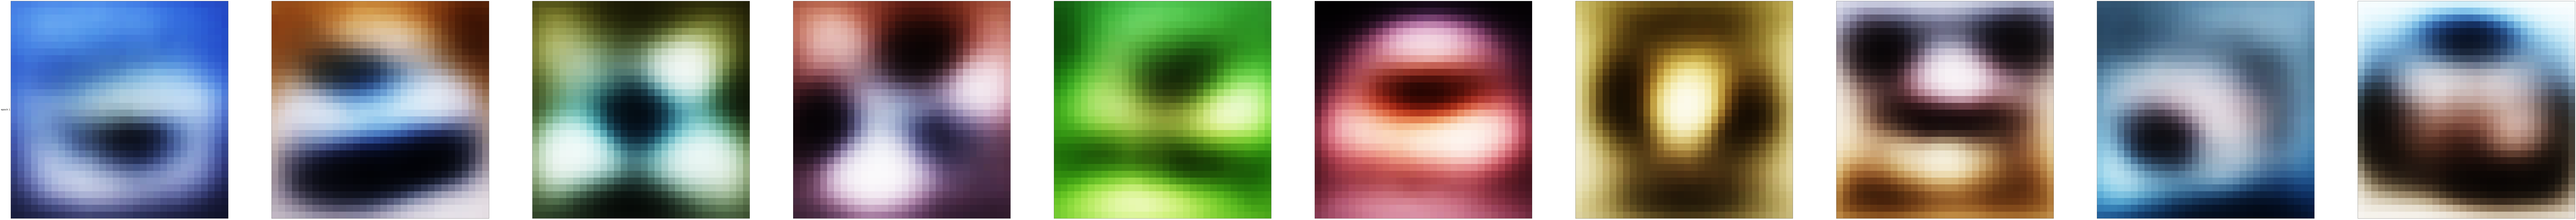

In [ ]:
plot_samples([samples[80]])

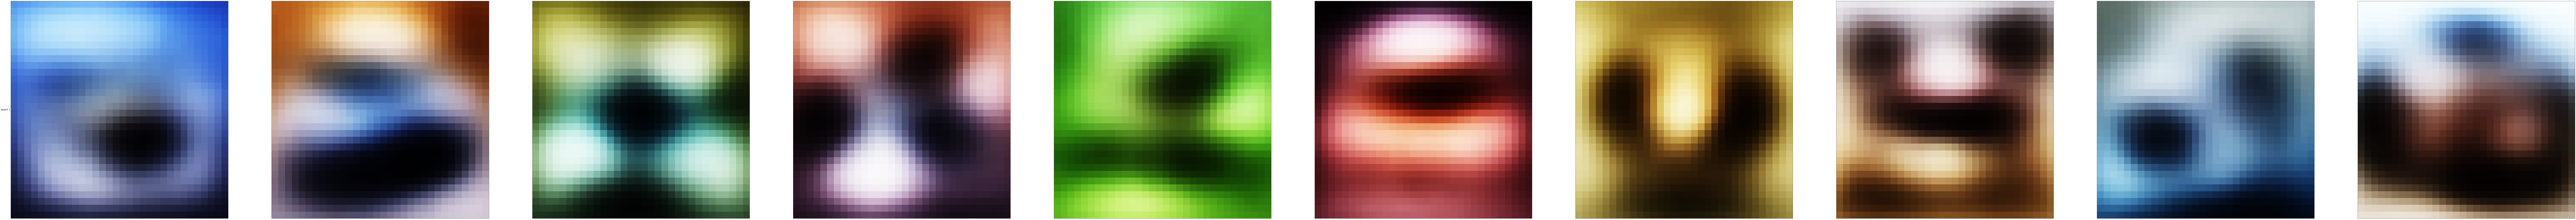

In [ ]:
plot_samples([samples[90]])

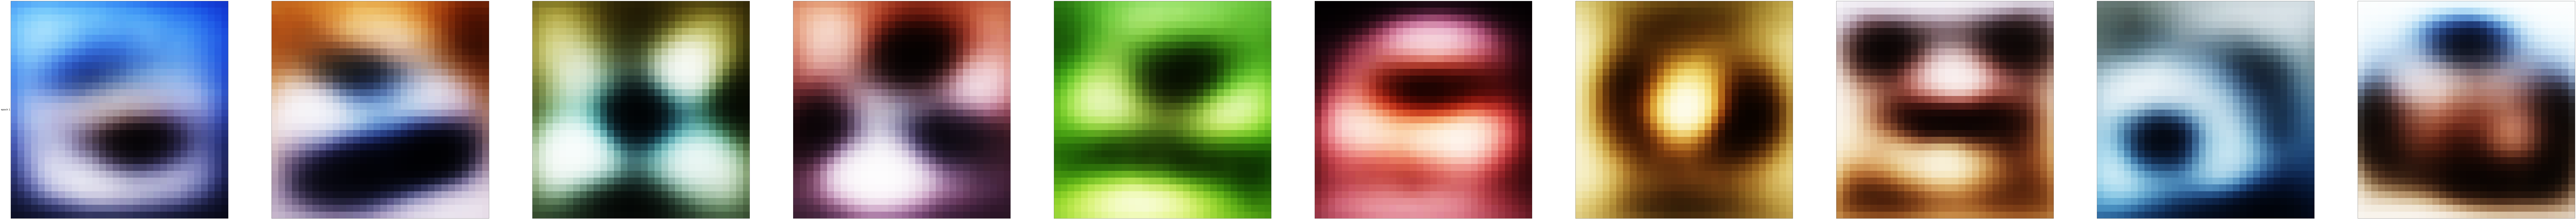

In [ ]:
plot_samples([samples[99]])

In [ ]:
samples[20].shape

(10, 3072)

In [ ]:
import cv2
from IPython.display import display, Image

(3072,)


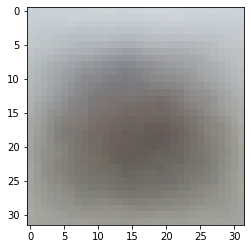

In [ ]:
img = samples[0][1]
print(img.shape)
plt.imshow(img.reshape((32, 32, 3)))

(3072,)


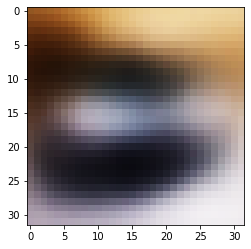

In [ ]:
img = samples[20][1]
print(img.shape)
plt.imshow(img.reshape((32, 32, 3)))

In [ ]:
len(samples)

25

In [ ]:
samples[0].shape

(10, 3072)

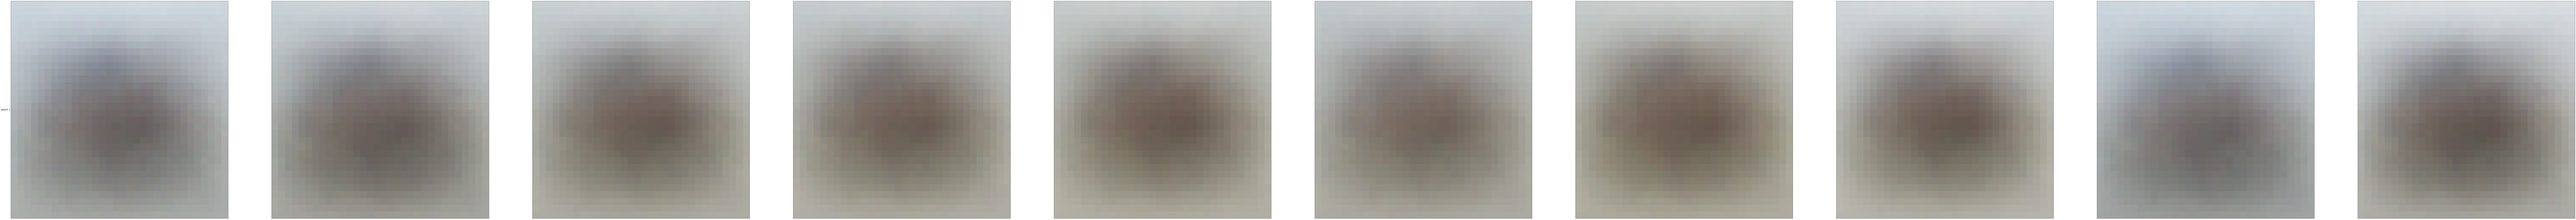

In [ ]:
def plot_samples(samples):
    IMAGE_WIDTH = 1.2
    plt.figure(figsize=(32 * num_digits,
                        len(samples) * 32))
    for epoch, images in enumerate(samples):
        for digit, image in enumerate(images):
            plt.subplot(len(samples),
                        num_digits,
                        epoch * num_digits + digit + 1)
            plt.imshow(image.reshape((32, 32, 3)))
            plt.gca().xaxis.set_visible(False)
            if digit == 0:
                plt.gca().yaxis.set_ticks([])
                plt.ylabel('epoch {}'.format(epoch + 1),
                           verticalalignment='center',
                           horizontalalignment='right',
                           rotation=0,
                           fontsize=16)
            else:
                plt.gca().yaxis.set_visible(False)
                
                
plot_samples([samples[0]])

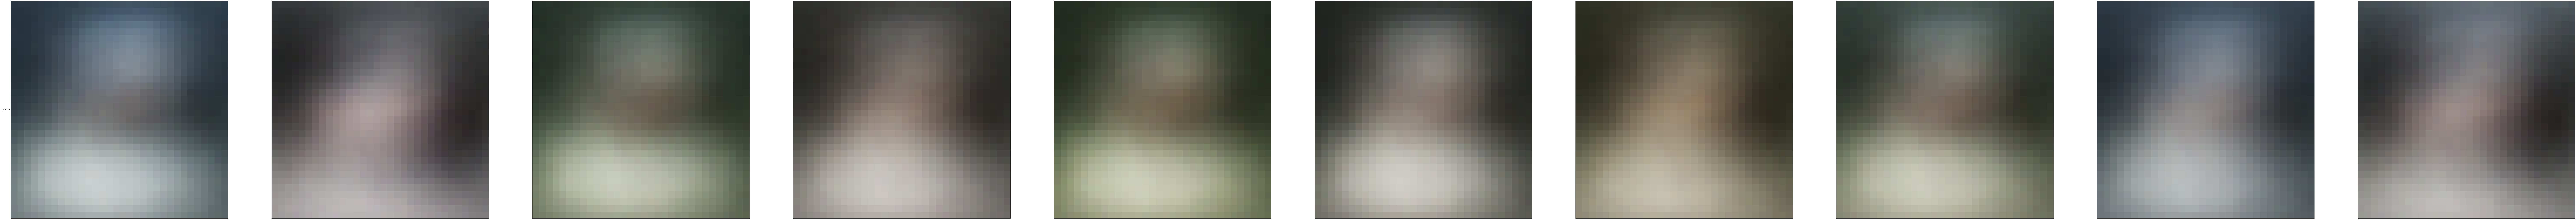

In [ ]:
plot_samples([samples[3]])

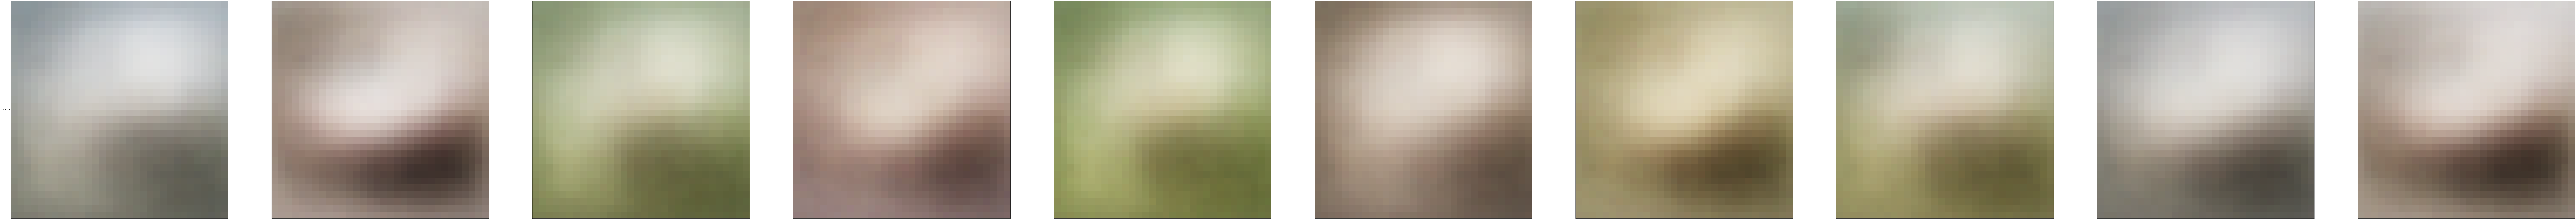

In [ ]:
plot_samples([samples[4]])

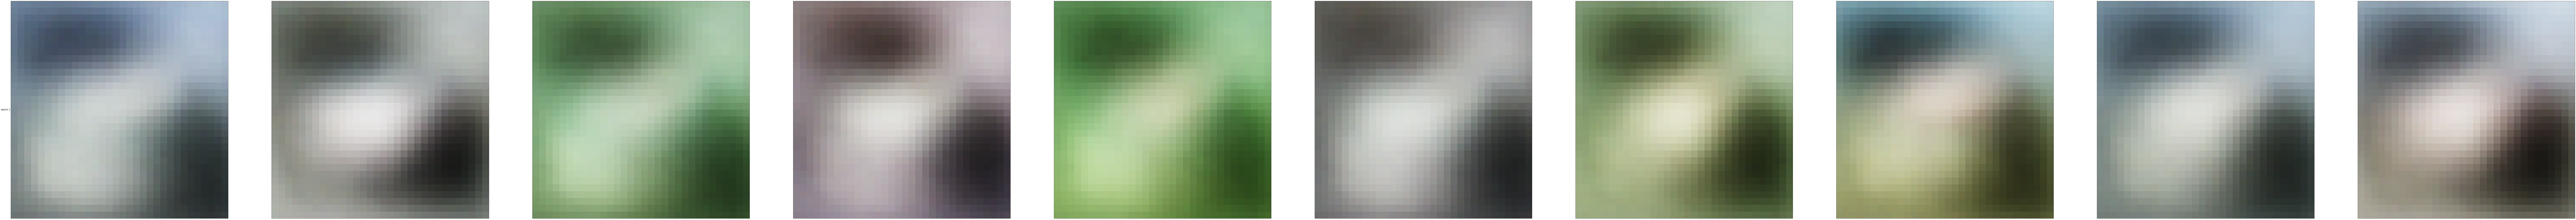

In [ ]:
plot_samples([samples[7]])

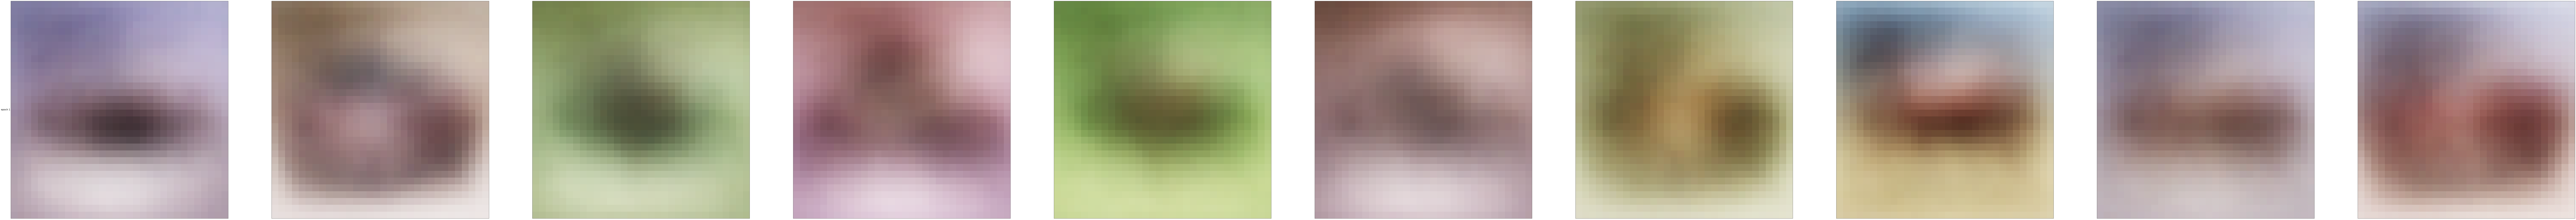

In [ ]:
plot_samples([samples[8]])

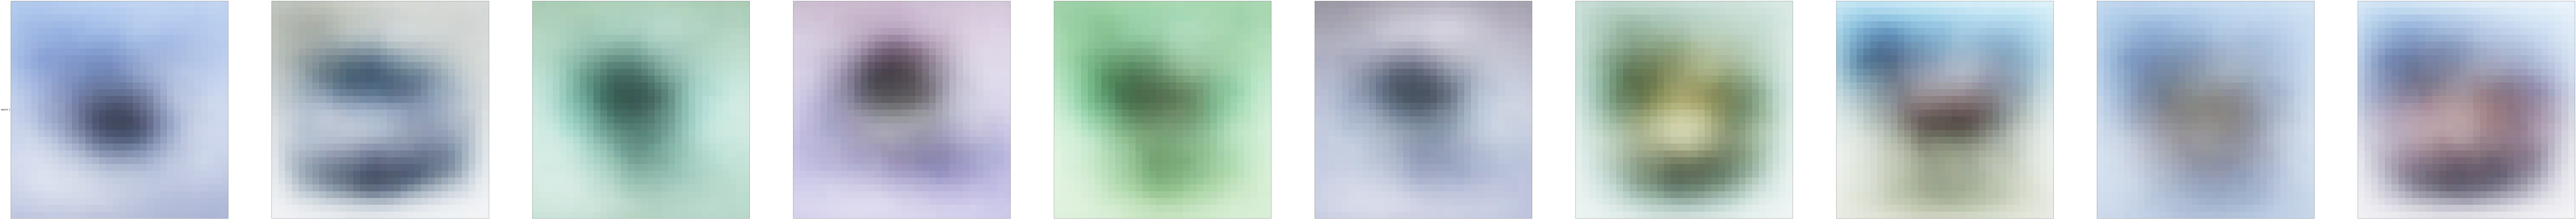

In [ ]:
plot_samples([samples[10]])

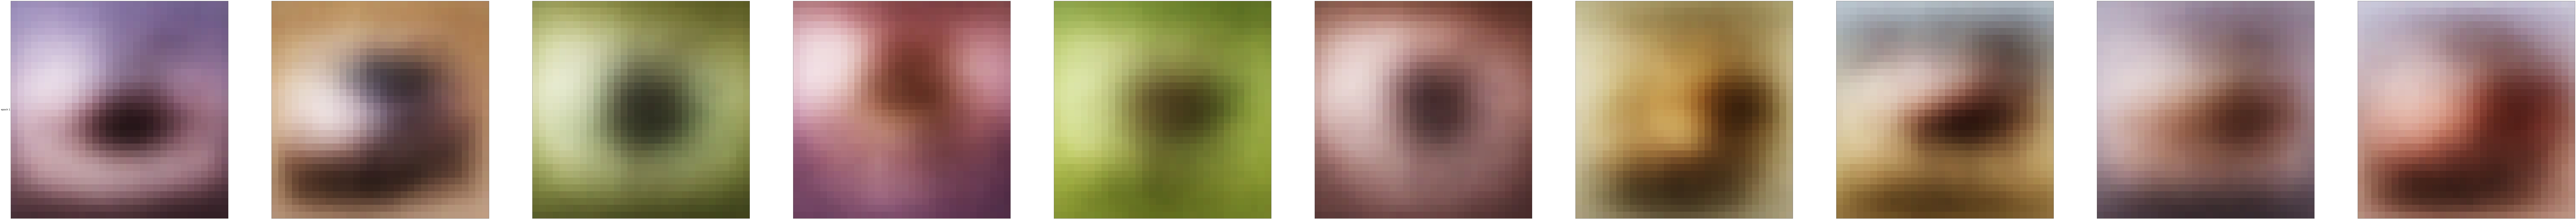

In [ ]:
plot_samples([samples[12]])

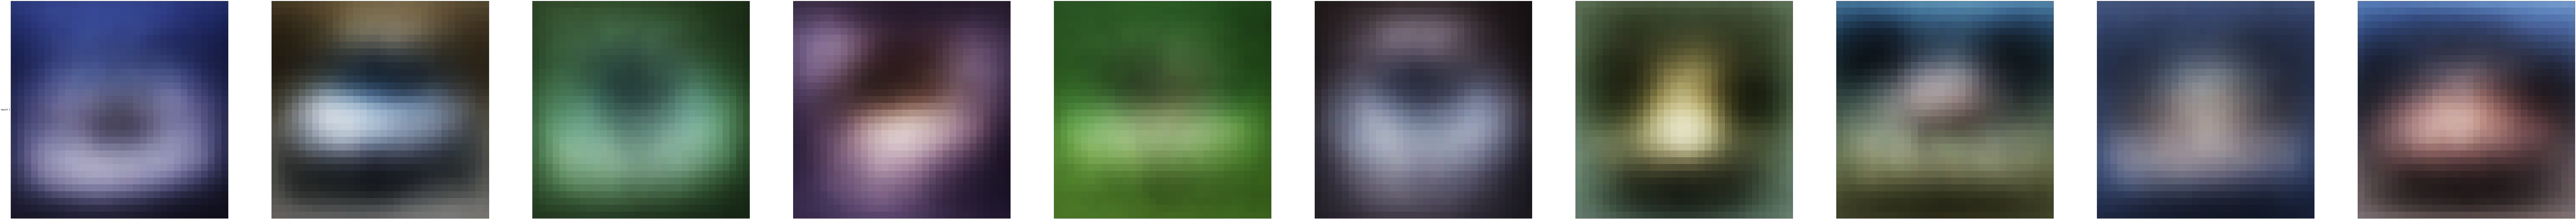

In [ ]:
plot_samples([samples[14]])

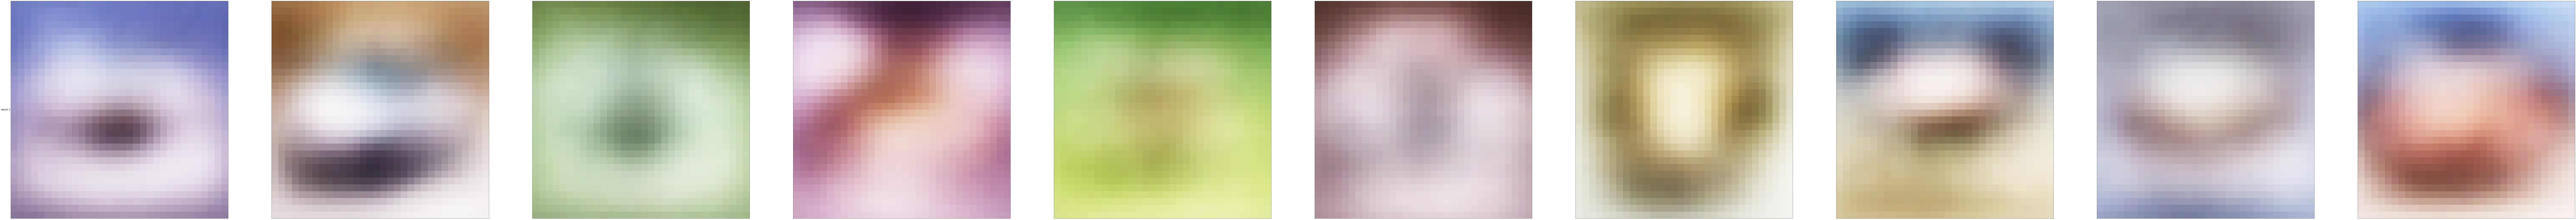

In [ ]:
plot_samples([samples[16]])

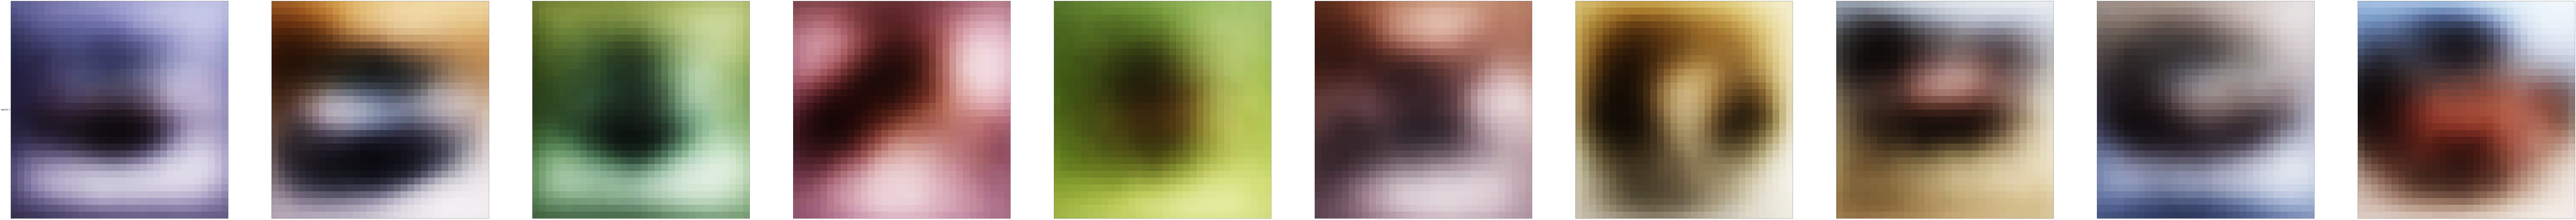

In [ ]:
plot_samples([samples[20]])

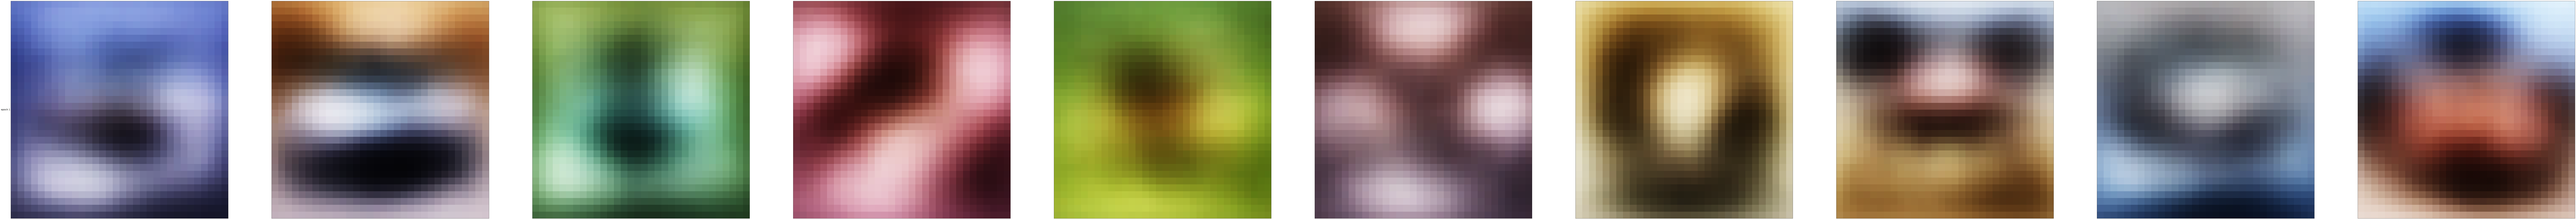

In [ ]:
plot_samples([samples[24]])

# Best examples (plot separately N images for every class)

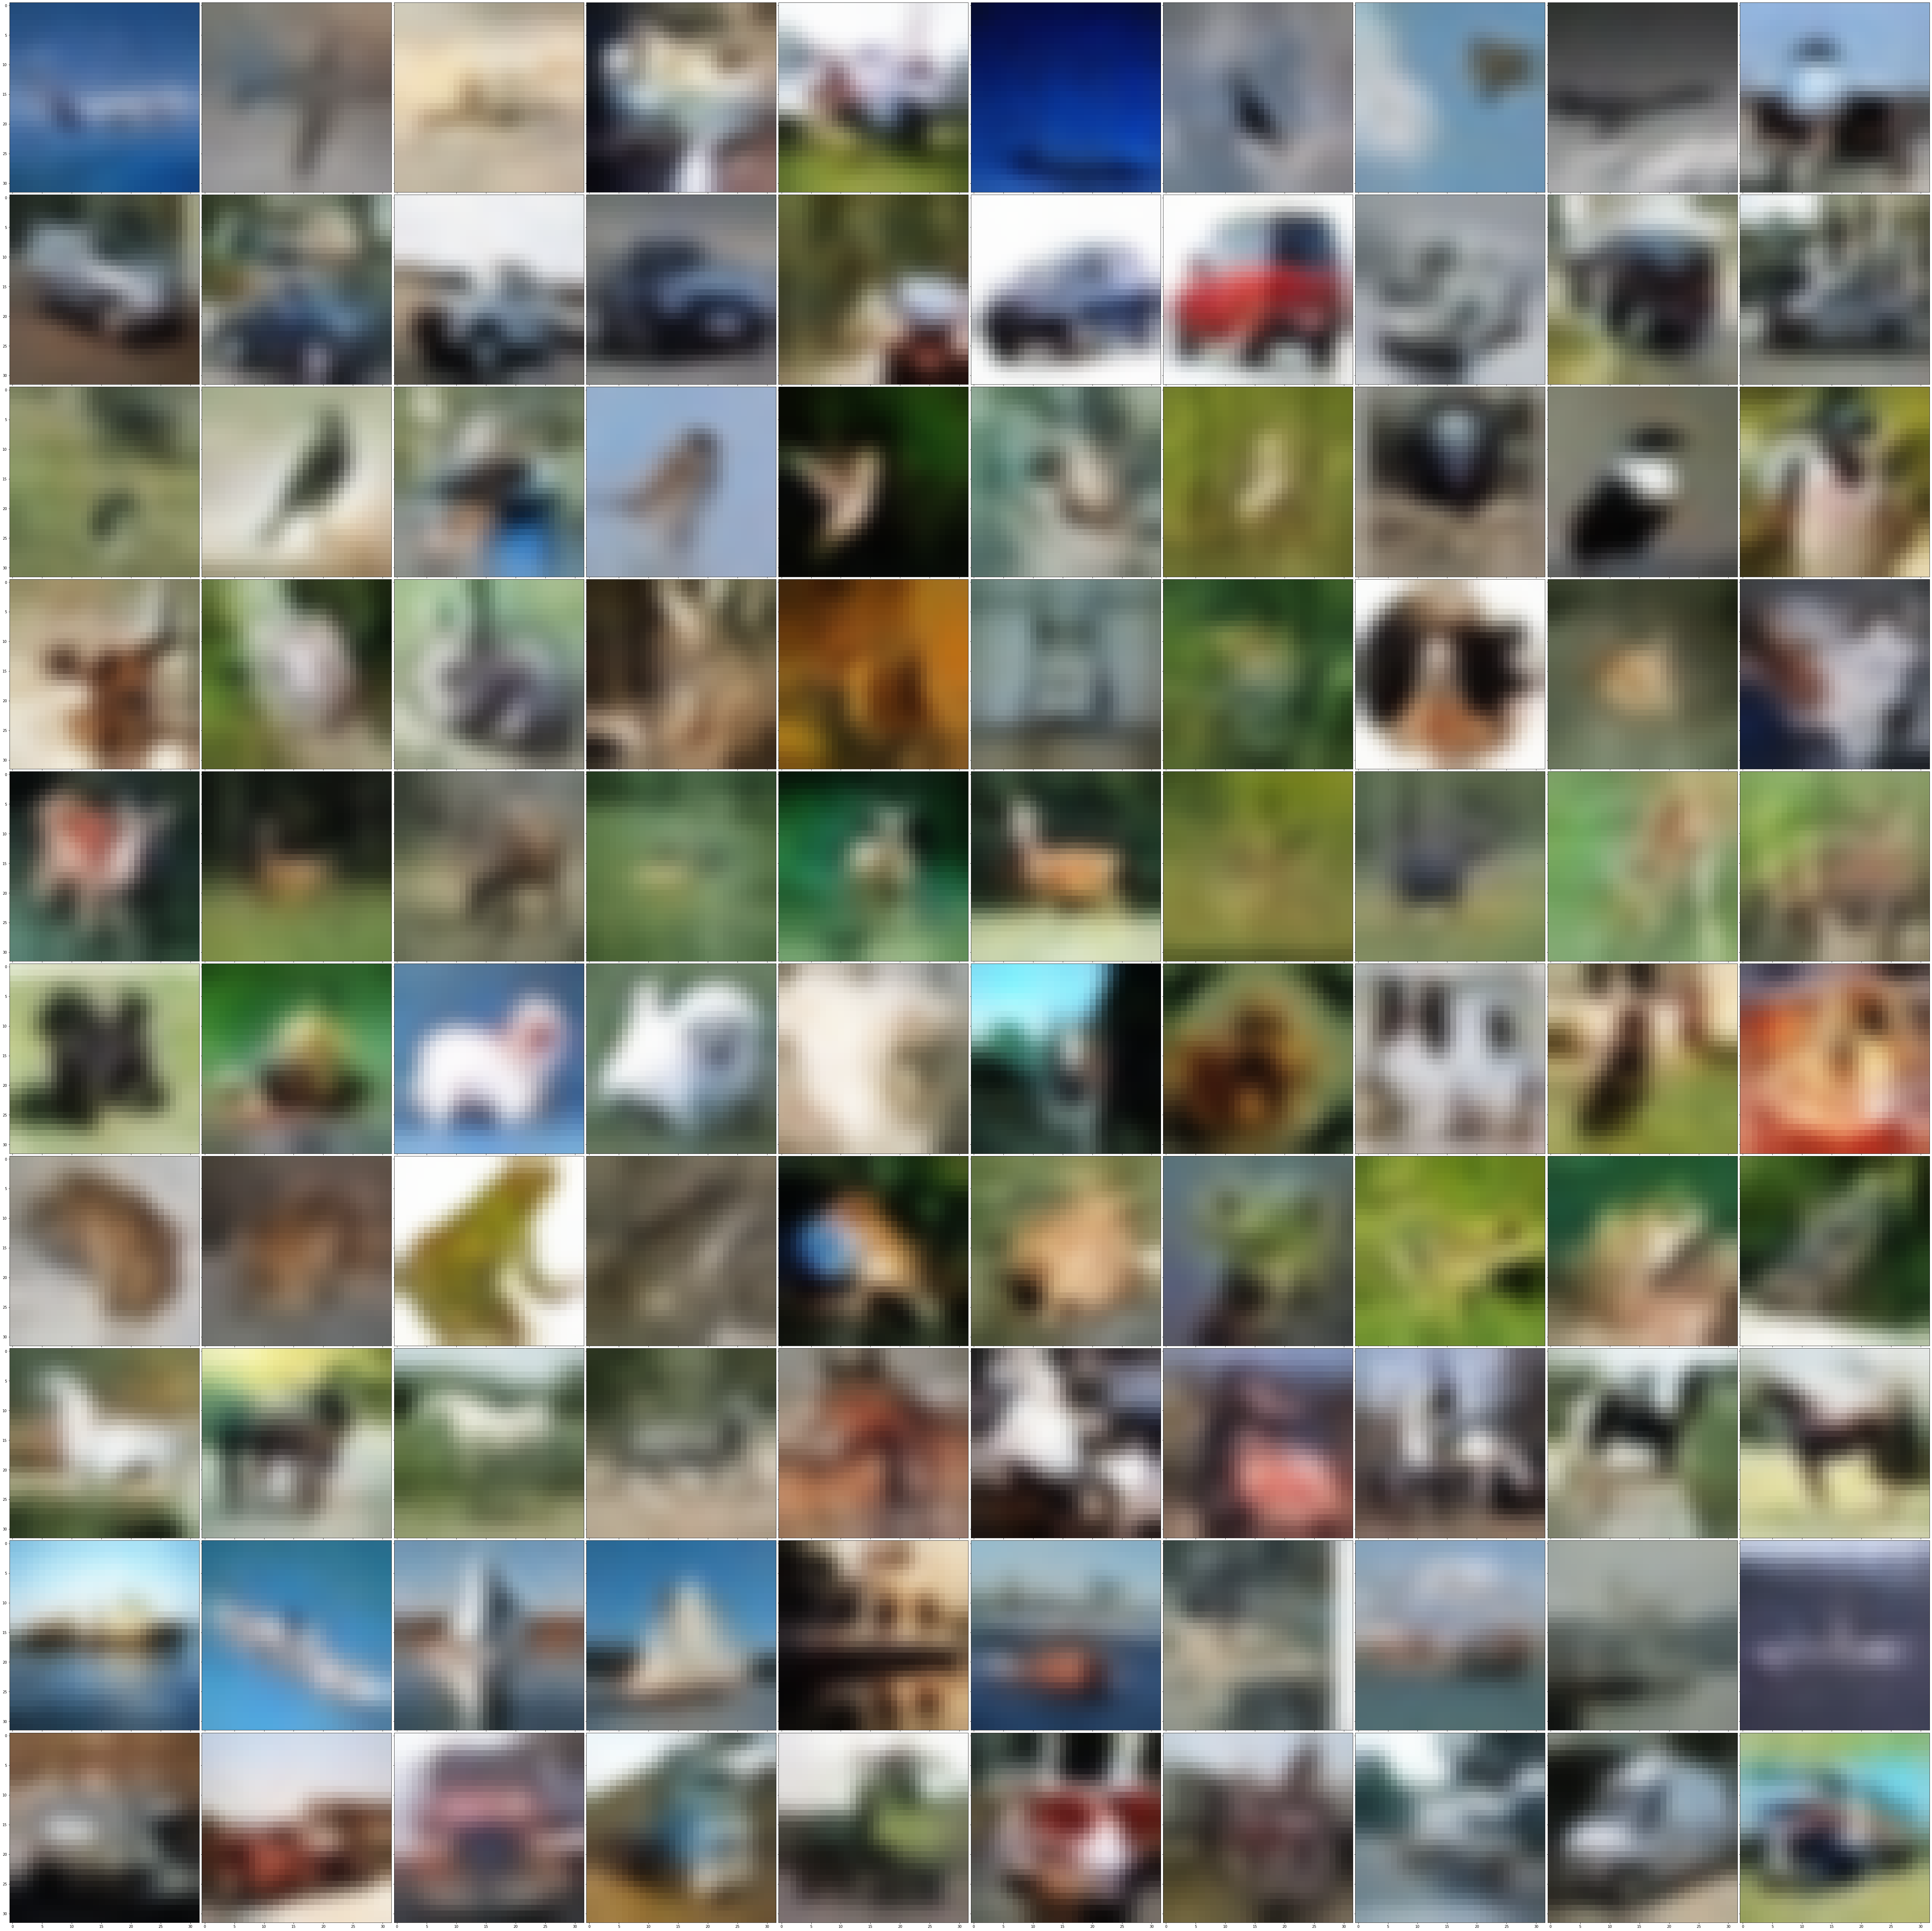

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import cv2

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, l2):
    # Iterating over the grid returns the Axes.
    X = im.reshape(1, 32, 32, 3)
    # X_recon = od.vae(X).numpy().reshape(32, 32, 3)
    # blur_image = cv2.GaussianBlur(X_recon, (7,7), 0)
    # ax.imshow(blur_image)
    ax.imshow(im)

plt.show()